In [8]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

import numpy as np 
import pandas as pd

from matplotlib import colormaps
from chromato.spaces import convert

import fastf1
import fastf1.plotting
from fastf1 import utils 

import time

session = fastf1.get_session(2025, 1, 'Q')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

teams = fastf1.plotting.list_team_names(session)
circuit_info = session.get_circuit_info()

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '63', '22', '23', '16', '44', '10', '55', '6', '14', '18', '7', '5', '12', '27', '30', '31', '87']


In [ ]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

def get_corner_dist_for_drivers(driver_tel):
    driver_corner_distance = []
    i= 0 
    for index, row in driver_tel.iterrows():
        distance = row['Distance']
        if i == len(circuit_info.corners):
            break
        elif distance > circuit_info.corners['Distance'][i]:
            driver_corner_distance.append(row)
            i+=1
    return driver_corner_distance

def add_turn(driver_tel):

    driver_distance = get_corner_dist_for_drivers(driver_tel)
    
    list_turn = []
    for i in range(len(driver_distance)):
        list_turn.append(driver_distance[i]['Distance'])
        
    turn_values = list(range(1, len(list_turn) + 1)) 
    list_turn = np.array([entry['Distance'] for entry in driver_distance])
    values = driver_tel['Distance'].values
    turn = np.zeros_like(values, dtype=int)
    for i, val in enumerate(values):
        for j in range(0, len(list_turn)): 
            if val <= list_turn[j]:
                turn[i] = turn_values[j]
                break
    return turn

def add_faster_driver(driver_tel, faster_driver, corner_distance):
    
    values = driver_tel['Turn'].values
    faster = np.zeros_like(values, dtype=int)
    for i, val in enumerate(faster_driver):
        if val == 1 :
            faster[values == i+1] = 1 
    return faster

def convert_for_cmap(base_color):
    base_color_rgb = convert.hex_to_rgb(base_color)
    r = base_color_rgb.r/255
    g = base_color_rgb.g/255
    b = base_color_rgb.b/255
    
    return r, g, b

def get_delta_per_team(team_drivers, quali_session):
    driver0_lap = quali_session.pick_drivers(team_drivers[0]).pick_fastest()
    driver1_lap = quali_session.pick_drivers(team_drivers[1]).pick_fastest()
    
    if type(driver0_lap) != type(None) and type(driver1_lap) != type(None):
        delta_time, ref_tel, compare_tel = utils.delta_time(driver0_lap, driver1_lap)
        max_delta = max(abs(min(delta_time)), abs(max(delta_time))) + 0.1 

    delta_time_at_corner = [0]
    for idx_corner, corner in circuit_info.corners.iterrows():
            for idx_dist ,dist in ref_tel['Distance'].items():
                    if dist > corner['Distance']:
                            delta_time_at_corner.append(round(delta_time[idx_dist],3))
                            break
    delta_time_at_corner_diff = np.diff(delta_time_at_corner).tolist()
    delta_time_at_corner_diff = [round(elem, 3) for elem in delta_time_at_corner_diff]
    delta_per_team.update({f'{sub_session}_{team}': delta_time_at_corner_diff})
    return delta_per_team

def show_corner_advantage_per_quali_session(team_drivers, quali_session):
    gaps = [1 if gap >= 0 else 0 for gap in delta_per_team[f'{sub_session}_{team}']]

    lap = session.laps.pick_drivers(team_drivers[0]).pick_fastest()
    tel = lap.get_telemetry()
    tel['Turn'] = add_turn(tel)
    corner_distance = circuit_info.corners['Distance']
    tel['faster_driver'] = add_faster_driver(tel, gaps, corner_distance)
    x = np.array(tel['X'].values)
    y = np.array(tel['Y'].values)
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    track_angle = circuit_info.rotation / 180 * np.pi
    rotated_track = rotate(points, angle=track_angle)
    segments = np.concatenate([rotated_track[:-1], rotated_track[1:]], axis=1)
    first_values = [pair[0][0] for pair in rotated_track]
    second_values = [pair[0][1] for pair in rotated_track]
    
    cmap = colormaps['Paired']

    tc_r , tc_g, tc_b = convert_for_cmap(team_color) 
    tc_r2 , tc_g2, tc_b2 = convert_for_cmap(team_color_2) 

    cdict = {
        'red': (
            (0.0, 0.0, tc_r2),
            (0.0, 0.0, 0.1),
            (1.0, tc_r, 1.0),
        ),
        'green': (
            (0.0, 0.0, tc_g2),
            (0.0, 0.0, 0.0),
            (1.0, tc_g, 0.0),
        ),
        'blue': (
            (0.0, 0.0, tc_b2),
            (0.0, 0.0, 0.0),
            (1.0, tc_b, 0.0),
        )
    }

    cmap = mcolors.LinearSegmentedColormap('my_colormap', cdict)
    lc_comp = LineCollection(segments,linewidths=4, cmap=cmap)
    lc_comp.set_array(tel['faster_driver'])

    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    plt.plot(first_values, second_values,
        color='grey', linestyle='-', linewidth=8)
    plt.plot(rotated_track[0], rotated_track[1])
    offset_vector = [1000, 0] 

    offset_angle = 1 / 180 * np.pi
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)
    txt_sl ='Start / Finish Line'
    txt_sl_x = tel['X'].iloc[0] + offset_x
    txt_sl_y = tel['Y'].iloc[0] + offset_y
    txt_sl_x, txt_sl_y = rotate([txt_sl_x, txt_sl_y], angle=track_angle)
    plt.text(txt_sl_x, txt_sl_y, txt_sl,
             va='center_baseline', ha='center', size='small', weight='bold', color='white')
    
    for _, corner in circuit_info.corners.iterrows():
        txt = f"{corner['Number']}{corner['Letter']}" 
        
        offset_angle = corner['Angle'] / 180 * np.pi
        offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

        text_x = corner['X'] + offset_x
        text_y = corner['Y'] + offset_y
        text_x, text_y = rotate([text_x, text_y], angle=track_angle)

        plt.text(text_x, text_y, txt,
                va='center_baseline', ha='center', size=16, weight='bold', color='white')
    
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    fig.tight_layout()

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '1', '63', '22', '23', '16', '44', '10', '55', '6', '14', '18', '7', '5', '12', '27', '30', '31', '87']
core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for t

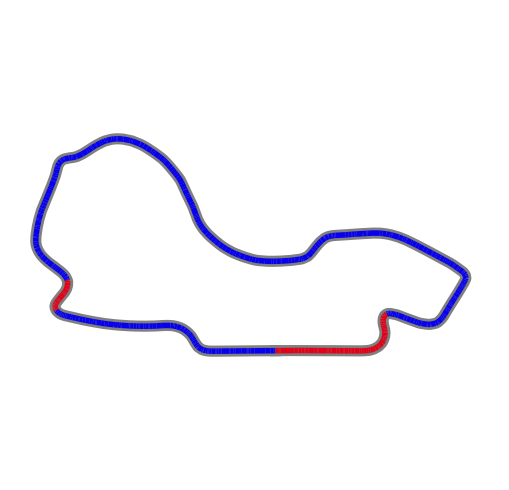

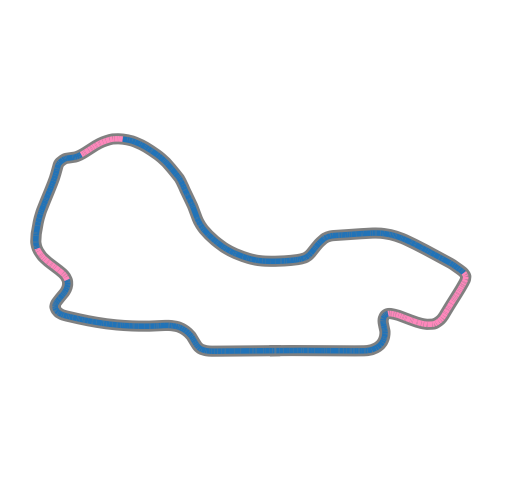

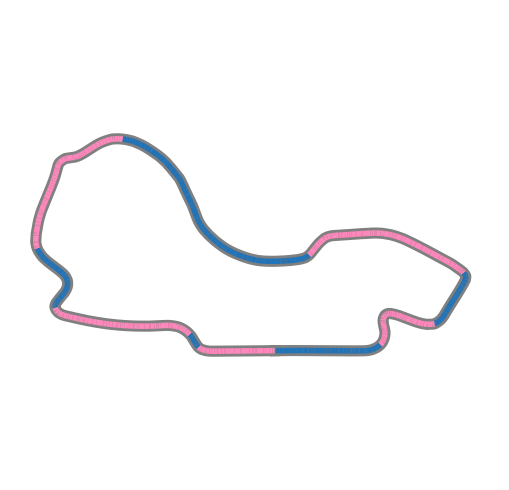

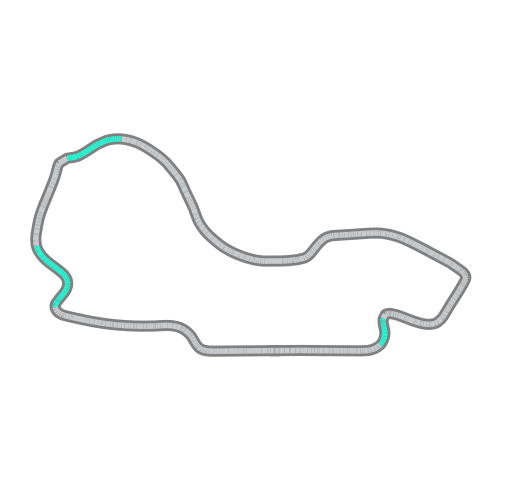

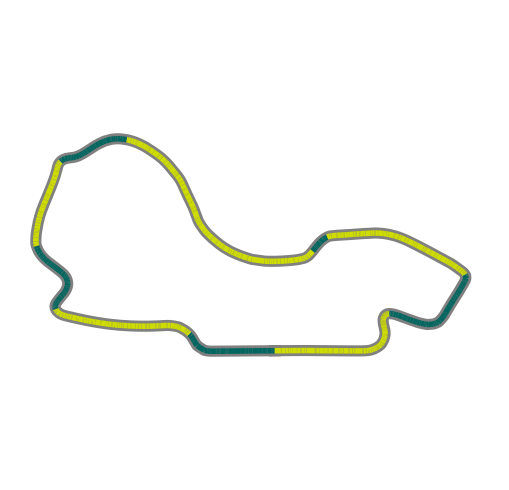

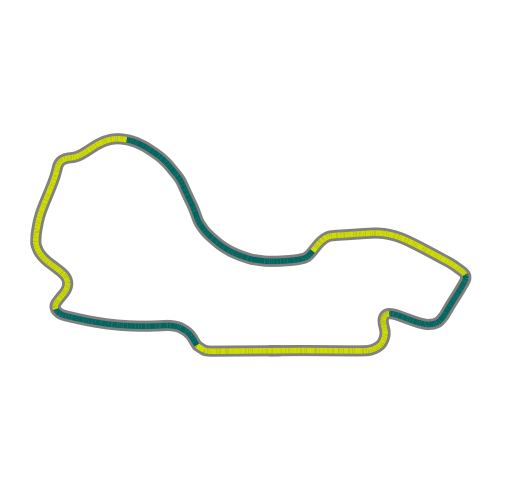

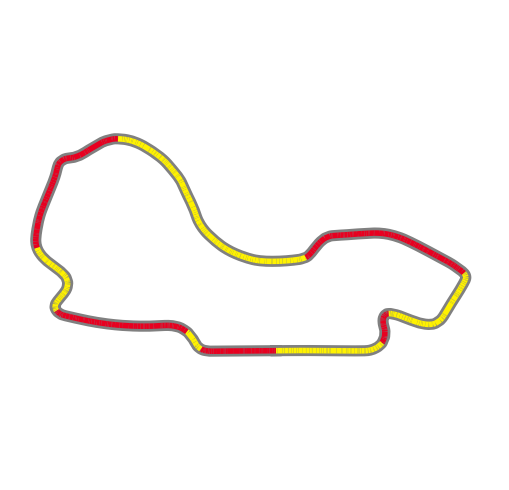

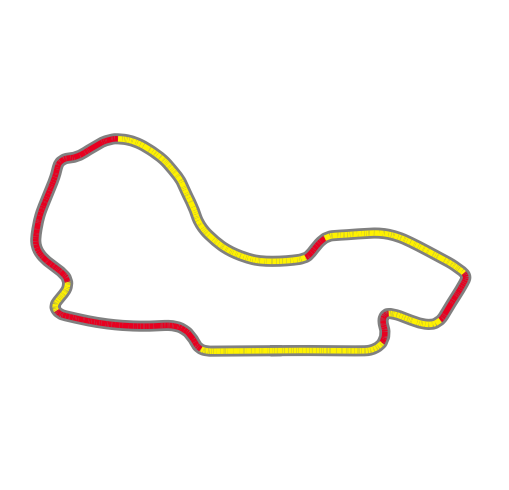

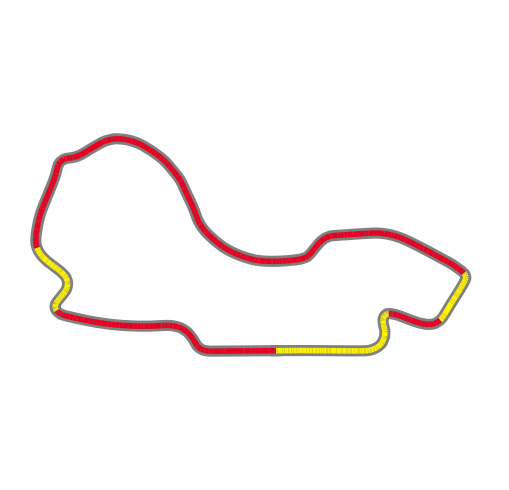

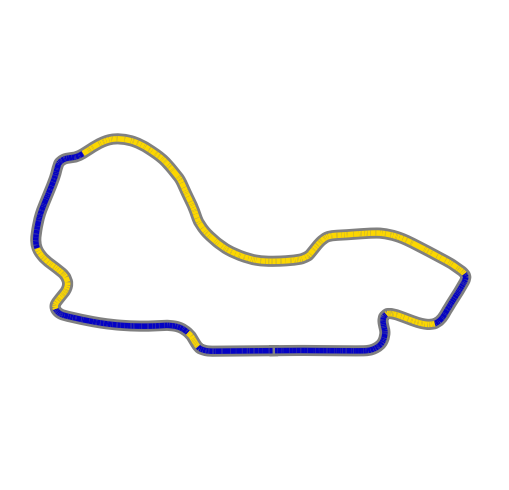

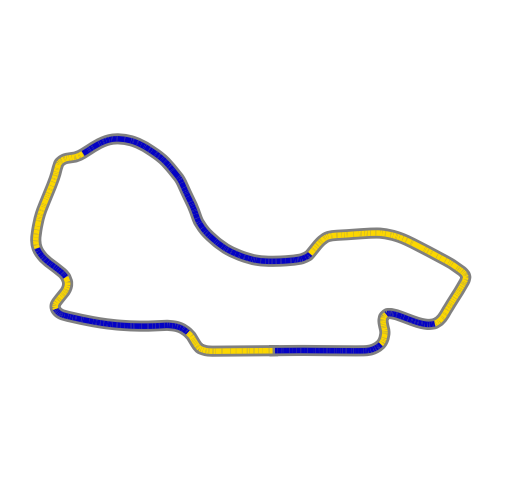

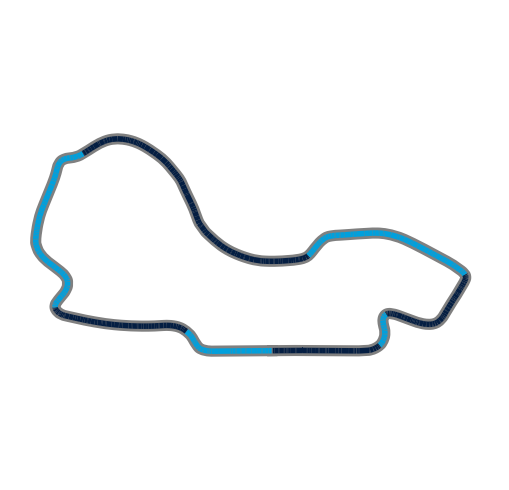

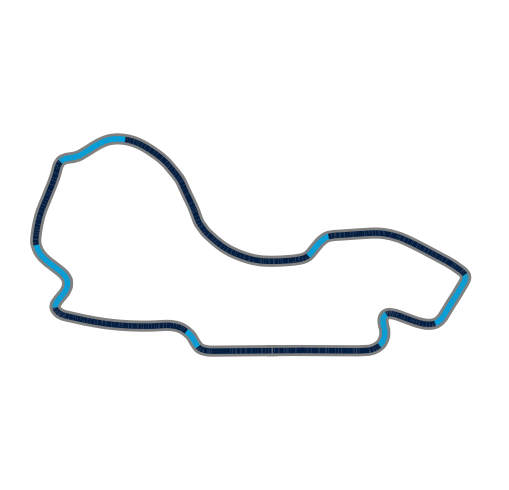

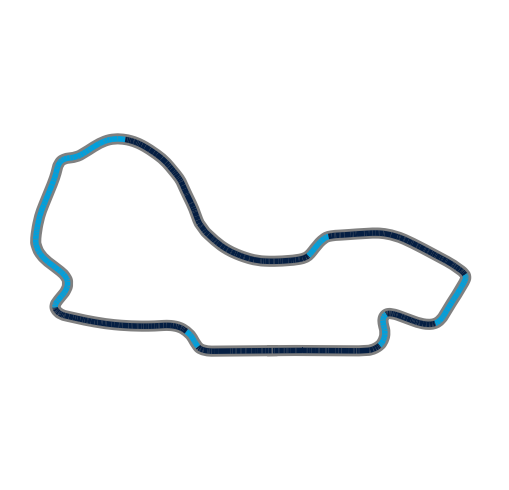

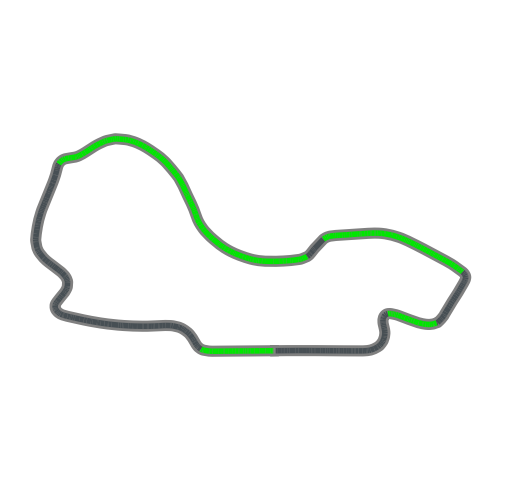

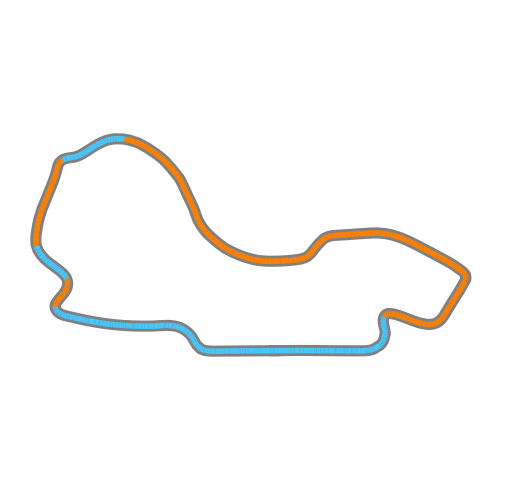

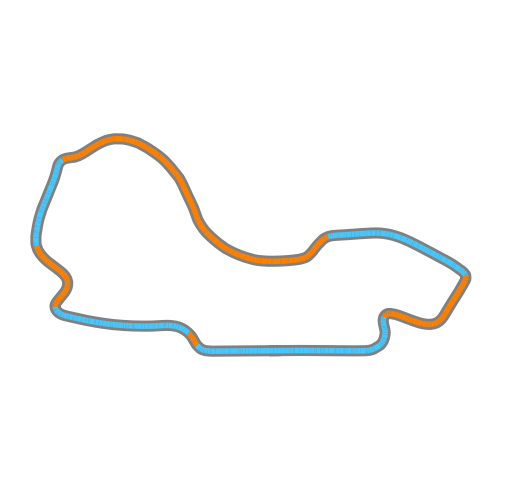

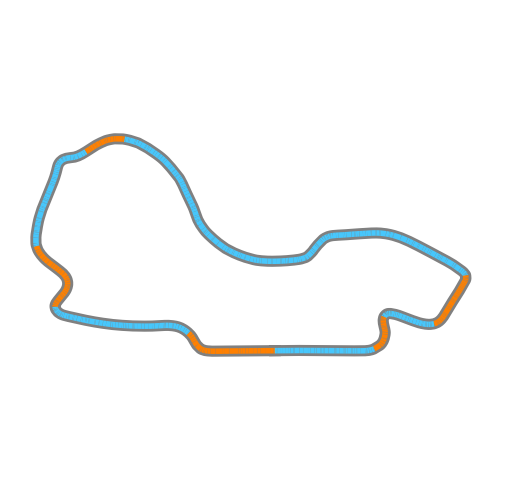

In [ ]:
#year = int(input('Year ? '))
#race_number = int(input('Race Number ? '))
#race_session = input('Session ? ')

year = 2025
race_number = 1
race_session = 'Q'

session = fastf1.get_session(year, race_number, race_session)
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

teams = fastf1.plotting.list_team_names(session)
circuit_info = session.get_circuit_info()

delta_per_team = {}

start_time = time.time()

session= fastf1.get_session(year, race_number, race_session)
session.load()
q1, q2, q3 = session.laps.split_qualifying_sessions()
is_nat = np.isnat(q1['LapTime'])
q1 = q1[~is_nat]
is_nat = np.isnat(q2['LapTime'])
q2 = q2[~is_nat]
is_nat = np.isnat(q3['LapTime'])
q3 = q3[~is_nat]
teams = fastf1.plotting.list_team_names(session)


#circuit_info = session.get_circuit_info()

for idx, team in enumerate(teams):
    team_drivers = fastf1.plotting.get_driver_abbreviations_by_team(team, session=session)
    team_color = fastf1.plotting.get_team_color(team, session=session)
    df_color=pd.read_csv("../data/raw/second_color.csv", index_col='team')
    team_color_2 = df_color.iat[idx,0]
    if team_drivers[0] in  q1['Driver'].values and team_drivers[1] in  q1['Driver'].values:
        sub_session = 'Q1'
        try:
            delta_per_team = get_delta_per_team(team_drivers, q1)
            show_corner_advantage_per_quali_session(team_drivers=team_drivers, quali_session = q1)
        except:
            print(f'No data in {sub_session} for {team}')
    if team_drivers[0] in  q2['Driver'].values and team_drivers[1] in  q2['Driver'].values:
        sub_session = 'Q2'
        try:
            delta_per_team = get_delta_per_team(team_drivers, q2)
            show_corner_advantage_per_quali_session(team_drivers=team_drivers, quali_session = q2)
        except:
            print(f'No data in {sub_session} for {team}')
    if team_drivers[0] in  q3['Driver'].values and team_drivers[1] in  q3['Driver'].values:
        sub_session = 'Q3'
        try:
            delta_per_team = get_delta_per_team(team_drivers, q3)
            show_corner_advantage_per_quali_session(team_drivers=team_drivers, quali_session = q3)
        except:
            print(f'No data in {sub_session} for {team}')